In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from maddeb.Deblender import Deblend
from maddeb.utils import listdir_fullpath
from maddeb.extraction import extract_cutouts

import numpy as np
import os

import matplotlib.pyplot as plt

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import tensorflow as tf
import tensorflow_probability as tfp
tf.get_logger().setLevel('ERROR')

from maddeb.utils import CustomSampling

2023-04-08 12:34:23.746193: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-04-08 12:34:23.746227: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
import seaborn as sns
sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

# Generate the blended scene

In [ ]:
COSMOS_CATALOG_PATHS = "/sps/lsst/users/bbiswas/OneDegSq_snr_10.fits"

stamp_size = 41
min_number = 1
max_number = 20
batch_size = 2
maxshift = 15
num_repetations = 15
catalog = btk.catalog.CatsimCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("LSST")
seed = 13
run_name = "test_run_catsim"

linear_norm_coeff = [1000, 5000, 10000, 10000, 10000, 10000]

sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_number, min_number=min_number, max_shift=maxshift, stamp_size=stamp_size, seed=seed
)

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    augment_data=True,
    verbose=False,
    seed=seed,
)

In [ ]:
blend = next(draw_generator)

blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])

Generating blends for LSST survey:   0%|          | 0/2 [00:00<?, ?it/s]

(6, 205, 205)

# Initialize the Deblender

In [ ]:
tf.get_logger().setLevel('ERROR')

deb = Deblend(latent_dim=16)

2023-04-08 12:34:59.744103: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-04-08 12:34:59.744137: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-08 12:34:59.744164: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2023-04-08 12:34:59.744361: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 12

### choose the field to deblend

In [ ]:
field_to_process = 1

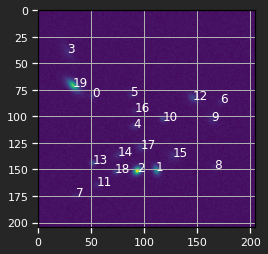

In [ ]:
#### print("input_image")
band_num = 2
plt.imshow(blend['blend_images'][field_to_process, band_num])
for i in range(len(blend['blend_list'][field_to_process])):
    plt.text(blend['blend_list'][field_to_process]['x_peak'][i], blend['blend_list'][field_to_process]['y_peak'][i], str(i))

input_image


/tmp/ipykernel_11636/2195325641.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  bar = fig.colorbar(im1, ax=ax)


<Figure size 720x720 with 0 Axes>

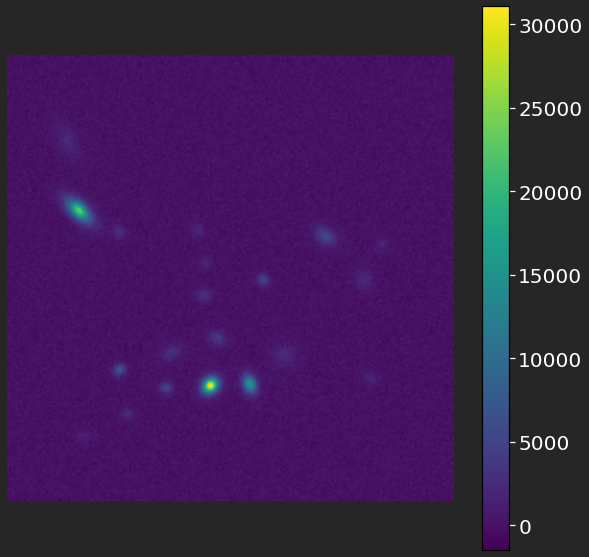

In [ ]:
fig = plt.figure(figsize=(10,10))
print("input_image")
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
im1 = ax.imshow(blend['blend_images'][field_to_process, 2])
#for i in range(len(blend['blend_list'][0])):
#    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
#                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
    #plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), c='black', fontsize=15)
bar = fig.colorbar(im1, ax=ax)
bar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("input field")


In [ ]:

# deb = Deblend(blend['blend_images'][0], 
#               detected_positions,
#               latent_dim=16, 
#               num_components=len(blend['blend_list'][0]), 
#               use_log_prob=True, 
#               linear_norm_coeff=linear_norm_coeff,
#               max_iter=500)



# Test run Debvader

In [ ]:
# deb.run_debvader()

In [ ]:
# fig, ax = plt.subplots(len(blend['blend_list'][0]), 3, figsize=(5*3,5*len(blend['blend_list'][0])))

# for i in range(len(blend['blend_list'][0])):

#     #print("image number: " + str(i))
#     image_index = i
#     im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i], detected_positions[i], 9))
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 0].set_title("ground truth")
#     ax[i, 0].scatter(22, 22, c="r", marker="x")

#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 1].set_title("predicted")
    
#     im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i], detected_positions[i], 9) - deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im3, ax=ax[i, 2])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 2].set_title("actual - predicted")
    
# plt.show()

In [ ]:
# Residual after debvader run

# fig = plt.figure(figsize=(10,10))
# ax = fig.gca()
# padding_infos = deb.get_padding_infos()
# residual = deb.compute_residual(np.transpose(blend['blend_images'][field_to_process], axes=[1, 2, 0]), use_scatter_and_sub=True).numpy()
# #residual = np.transpose(deb.postage_stamp, 
# im1 = ax.imshow(residual[:, :, 3])
# cbar =fig.colorbar(im1, ax=ax)
# cbar.ax.tick_params(labelsize=20)
# plt.savefig("residual")

In [ ]:
# fig, ax = plt.subplots(len(blend['blend_list'][0]), 2, figsize=(5*2,5*len(blend['blend_list'][0])))

# for i in range(len(blend['blend_list'][0])):

#     im1 = ax[i, 0].imshow(extract_cutouts(blend['isolated_images'][0][i], [detected_positions[i]], distances_to_center=False, cutout_size=45)[0][0, :, :, 2])
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=20)
#     ax[i, 0].set_title("ground truth", fontsize=20)
#     ax[i, 0].scatter(22, 22, c="r", marker="x")
#     ax[i, 0].axis('off')


#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=20)
#     ax[i, 1].set_title("predicted", fontsize=20)
#     ax[i, 1].axis('off')

# plt.show()

# Run MADNESS

In [ ]:
import tensorflow_addons as tfa
# convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
#     atol=0.000001 * 45 * 45 * len(blend) * 3, min_num_steps=80, window_size=20
# )

# convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
#     atol=0.0001 * 45 * 45 * len(blend) * 3, rtol=.001, min_num_steps=80, window_size=20
# )

convergence_criterion = tfp.optimizer.convergence_criteria.SuccessiveGradientsAreUncorrelated(min_num_steps=120, window_size=25)
# convergence_criterion = None
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.2, decay_steps=60, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
#optimizer=tfa.optimizers.AdaBelief(learning_rate=lr_scheduler)

detected_positions = []
for i in range(len(blend['blend_list'][field_to_process])):
    detected_positions.append([blend['blend_list'][field_to_process]['y_peak'][i], blend['blend_list'][field_to_process]['x_peak'][i]])

deb(postage_stamp=blend['blend_images'][field_to_process], 
    detected_positions=detected_positions,
    num_components=len(blend['blend_list'][field_to_process]), 
    use_log_prob=True, 
    linear_norm_coeff=linear_norm_coeff,
    max_iter=500,
    convergence_criterion=convergence_criterion,
    optimizer=optimizer,
    use_debvader=True,
    compute_sig_dynamically=False,
)

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Using encoder for initial point

--- Starting gradient descent in the latent space ---
Maximum number of iterations: 500
Number of Galaxies: 20
Dimensions of latent space: 16
--- Gradient descent complete ---

Time taken for gradient d

tf.Tensor(
[168598.67  159357.31  153474.28  149279.34  145598.61  142566.06
 140165.06  138353.08  137005.9   135949.98  135056.16  134271.7
 133571.27  132946.28  132390.73  131878.45  131387.4   130927.91
 130527.55  130200.12  129939.58  129730.87  129562.16  129389.11
 129196.68  128994.414 128800.14  128629.75  128486.38  128372.47
 128282.95  128216.65  128169.54  128132.67  128105.74  128079.99
 128046.04  128002.25  127950.6   127890.66  127828.11  127765.69
 127708.484 127654.86  127598.69  127535.875 127466.74  127400.25
 127343.12  127289.6   127233.086 127172.945 127111.59  127046.66
 126979.664 126912.23  126850.15  126796.18  126746.16  126692.984
 126648.7   126616.37  126589.15  126563.24  126538.86  126515.695
 126493.25  126471.27  126449.125 126427.12  126409.7   126394.95
 126377.24  126357.38  126337.05  126316.766 126296.38  126275.31
 126254.766 126236.664 126221.18  126206.58  126191.95  126177.39
 126163.59  126151.19  126139.93  126128.84  126117.62  126106.8

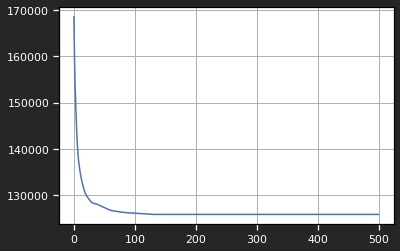

In [ ]:
print(deb.results)
plt.plot(deb.results);

/tmp/ipykernel_11636/3721990719.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im1, ax=ax[i, 0])
/tmp/ipykernel_11636/3721990719.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im1, ax=ax[i, 1])
/tmp/ipykernel_11636/3721990719.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im2, ax=ax[i, 2])
/tmp/ipykernel_11636/3721990719.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) fir

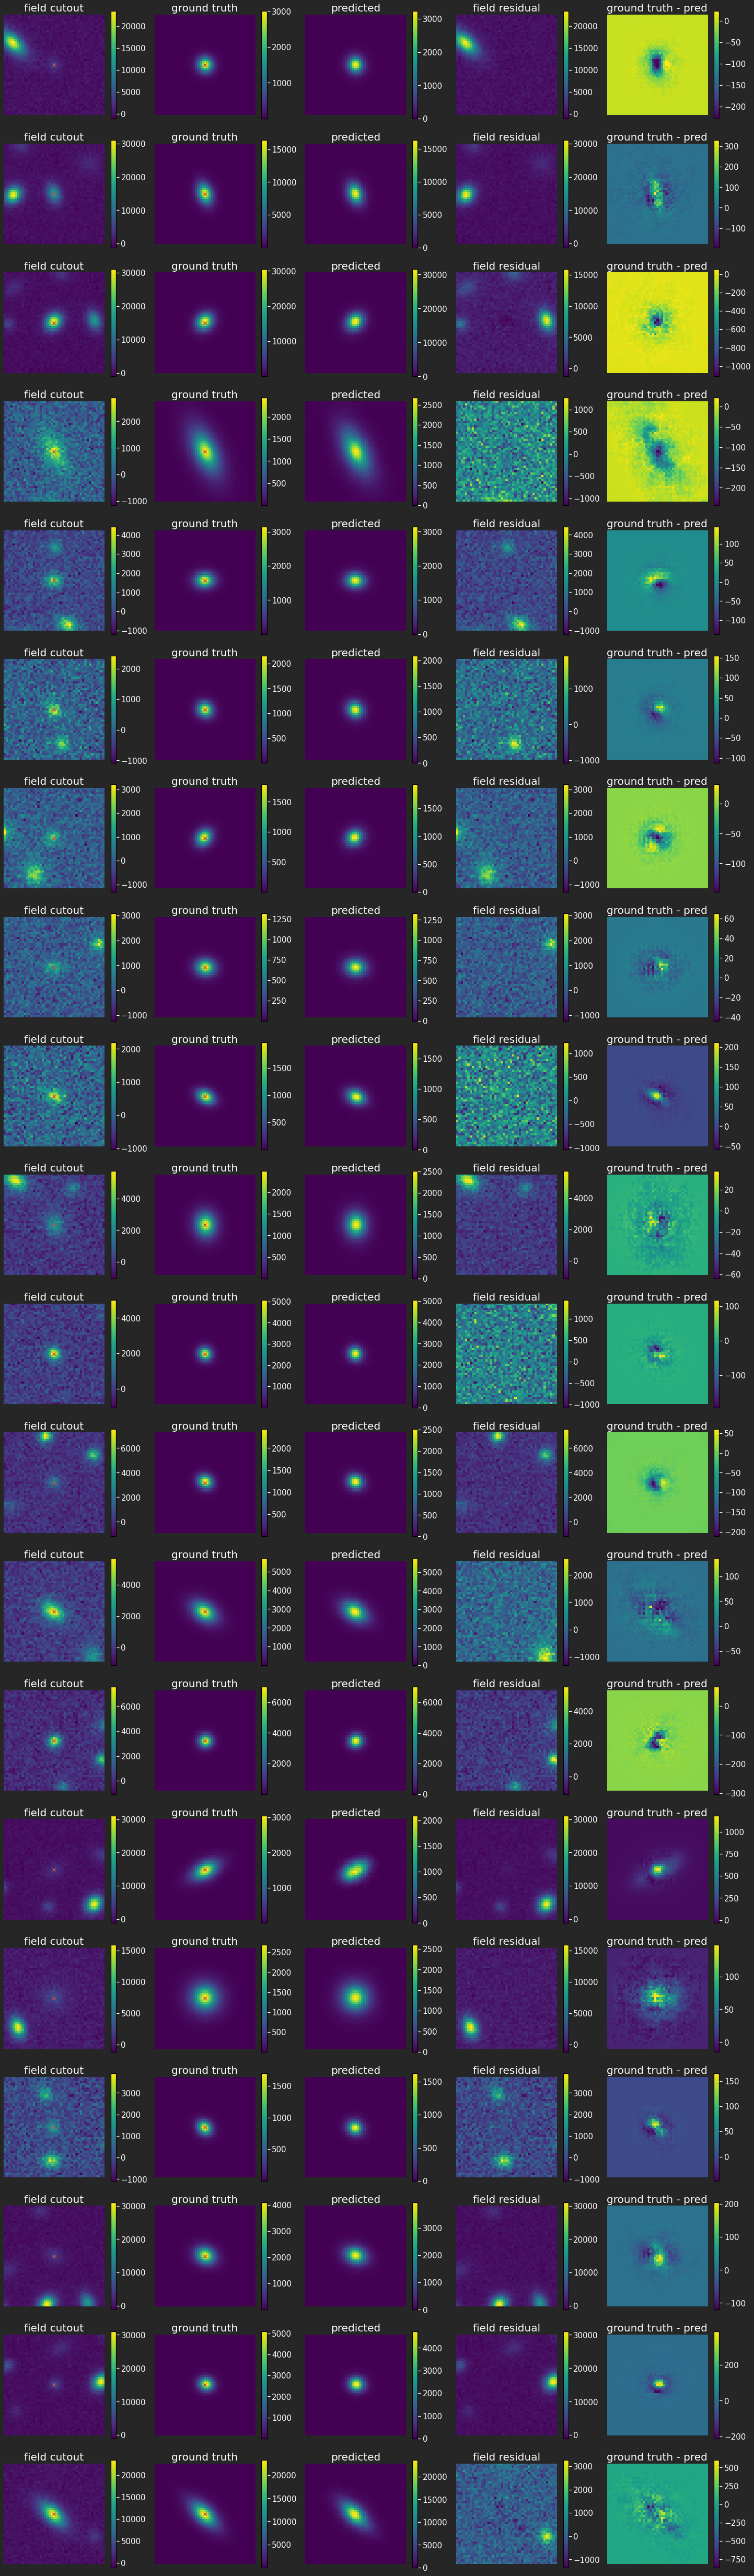

In [ ]:
fig, ax = plt.subplots(len(blend['blend_list'][field_to_process]), 5, figsize=(5*5,5*len(blend['blend_list'][0])))

for i in range(len(blend['blend_list'][field_to_process])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    field_cutout_r_band = extract_cutouts(blend['blend_images'][field_to_process], [detected_positions[i]], distances_to_center=False, channel_last=False, cutout_size=45)[0][0,:, :, 2]
    galaxy_cutout_r_band = extract_cutouts(blend['isolated_images'][field_to_process][i], [detected_positions[i]], distances_to_center=False, cutout_size=45)[0][0, :, :, 2]
    
    im1 = ax[i, 0].imshow(field_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 0].set_title("field cutout", fontsize=20)
    ax[i, 0].scatter(22, 22, c="r", marker="x")
    ax[i, 0].axis('off')

    im1 = ax[i, 1].imshow(galaxy_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 1].set_title("ground truth", fontsize=20)
    ax[i, 1].scatter(22, 22, c="r", marker="x")
    ax[i, 1].axis('off')


    im2 = ax[i, 2].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 2].set_title("predicted", fontsize=20)
    ax[i, 2].axis('off')
    
    im3 = ax[i, 3].imshow(field_cutout_r_band - deb.components[i][:, :, 2])
    cbar = fig.colorbar(im3, ax=ax[i, 3])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 3].set_title("field residual", fontsize=20)
    ax[i, 3].axis('off')

    
    im3 = ax[i, 4].imshow(galaxy_cutout_r_band - deb.components[i][:, :, 2])
    cbar = fig.colorbar(im3, ax=ax[i, 4])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 4].set_title("ground truth - pred", fontsize=20)
    ax[i, 4].axis('off')

plt.savefig("MAP_predictions")
plt.show()

In [ ]:
# fig, ax = plt.subplots(1, len(blend['blend_list'][0]), figsize=(5*len(blend['blend_list'][0]), 5*1))
# for i in range(len(blend['blend_list'][0])):

#     #print("image number: " + str(i))
#     #image_index = shuffled_indices[i]

#     im2 = ax[i].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i].axis("off")
#     #ax[i].set_title("predicted")
# plt.savefig("predictions")

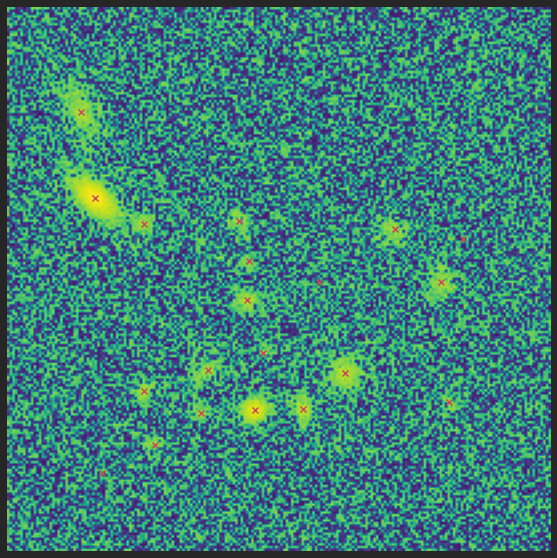

In [ ]:
# This is just to make the blends more visible

sns.set_theme(style={"axes.grid": False,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.arcsinh(blend['blend_images'][field_to_process][0]))
for i in range(len(blend['blend_list'][field_to_process])):
    plt.scatter(blend['blend_list'][field_to_process]['x_peak'][i], 
                blend['blend_list'][field_to_process]['y_peak'][i], marker="x", c="r")

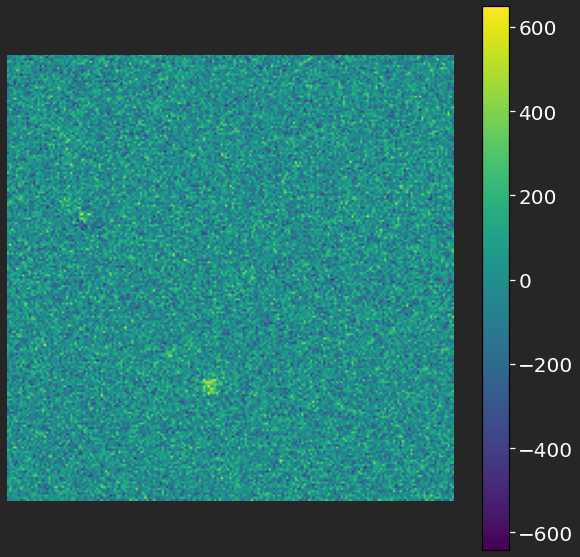

In [ ]:
# Residual after MADNESS run
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(np.transpose(blend['blend_images'][field_to_process], axes=[1, 2, 0]), use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 1])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("residual")

#for i in range(len(blend['blend_list'][0])):
    #plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

##### sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

plt.figure(figsize=(8,3))
residual_flattened = residual[:, :, 0].flatten()
print(np.shape(residual_flattened))
plt.hist(residual_flattened, bins=50)
plt.xticks(fontsize=15)
plt.yticks([])

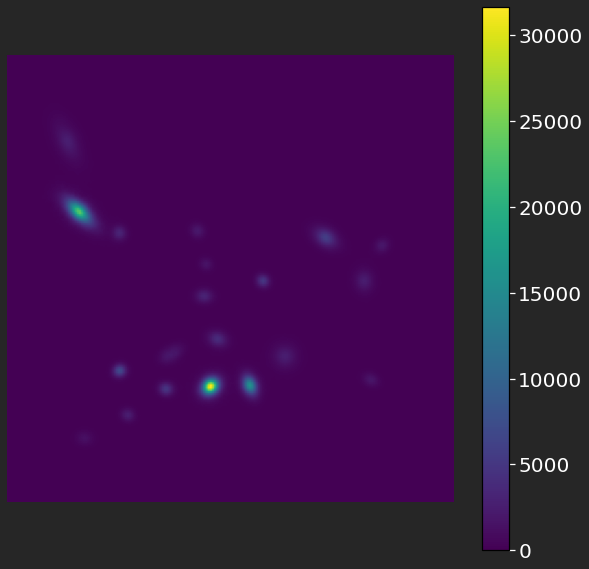

In [ ]:
sns.set_theme(style={"axes.grid": False,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})
predicted_field = blend['blend_images'][field_to_process] - np.transpose(residual, axes=[2, 0, 1])
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
im1 = ax.imshow(predicted_field[2, :, :])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.show();